## Load spread sheet

In [348]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

In [349]:
# Load data from spreadsheet.
data_frame = pd.read_excel(
    '2019-08-27_PLASMA_DEFAULT_Results_Groningen.xlsx',
    sheet_name=2,
)

To make a fair comparison we should split the data in a training and validation set by randomly selecting patients. 

In [369]:
# Fraction of dataset we want to use for the validation set.
f_val = 0.3

patients = data_frame['Patient ID'].unique()
np.random.shuffle(patients)

# Determine the largest element no longer in the training set.
cut_off = int(np.ceil(len(patients) * (1 - f_val)))
train_patients = patients[:cut_off]
test_patients = patients[cut_off:]

# Put records in train/validation set according to "Patient ID".
train_rows = data_frame['Patient ID'].isin(train_patients)
train_data_frame = data_frame.loc[train_rows]
test_data_frame = data_frame[~train_rows]

## Aggregated statistics
Let us first look at the data as a whole (not just the training data), to explore the dataset.

In [313]:
# Focus only on the genes
columns_to_keep = ['Patient ID', 'Gene']
data_frame = data_frame[columns_to_keep]

['TP53' 'KRAS' 'FGFR1' 'PTEN' 'FBXW7' 'KDR' 'MTOR' 'EGFR' 'MET' 'CDKN2A'
 'BRAF' 'APC' 'KEAP1' 'ALK' 'AR' 'ERBB2' 'NRAS' 'NFE2L2' 'TSC2' 'GNAS'
 'STK11' 'CD274' 'CTNNB1' 'MAP2K2' 'IDH1' 'NF2' 'MAP2K1' 'PIK3CA' 'IDH2'
 'FLT4' 'ESR1' 'DDR2' 'KIT' 'PTCH1' 'SMAD4' 'SMO' 'RNF43' 'FGFR2' 'JAK2'
 'CCND1' 'GATA3' 'PDGFRA']


Text(0, 0.5, '# occurences')

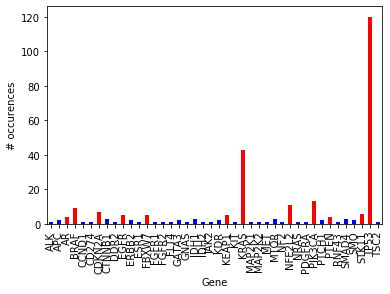

In [265]:
# Count occurences of genes, regardless of how many per patient.
gene_set = data_frame['Gene'].unique()
gene_count  = data_frame.groupby('Gene') \
    .count()

print(gene_set)
# Plot occurences of genes, and make all genes with more than 3 instances red.
gene_colour = gene_count['Patient ID'].apply(lambda x: 'red' if x > 3 else 'blue')
ax = gene_count['Patient ID'].plot(kind='bar', color=gene_colour)
ax.set_ylabel('# occurences')

Clearly, the majority of the mutations are unique, whilst the presence of TP53 is quite ubiquitous. 

How are the mutations distributed? One per patient?

(1, 11)

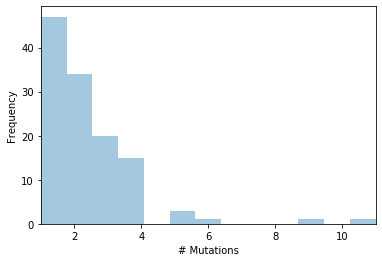

In [268]:
# How many mutations per patient?
mutation_counts = data_frame.groupby('Patient ID').count()
ax = sns.distplot(mutation_counts, kde=False)
ax.set_xlabel('# Mutations')
ax.set_ylabel('Frequency')
ax.set_xlim([1, max(mutation_counts['Gene'])])

The figure above indicates that patients usually have one or two mutations. 
But it can happen that there are multiple mutations in the same gene.

How often does this occur?

In [290]:
# How many patients have more than 1 mutation in the same gene?
# Group by (patient, gene):
num_gene_mutations = data_frame.groupby(columns_to_keep) \
    .size() \
    .to_frame('size')
# More than 1.
same_gene_mutations = num_gene_mutations[num_gene_mutations['size'] > 1]

# Fraction of total.
print('Number of patients with multiple mutations: {}/{} ({:.2f} %)'.format(
    same_gene_mutations.size, 
    data_frame.shape[0], 
    f * 100.0),
)

Number of patients with multiple mutations: 24/276 (8.70 %)


But how many mutations, and what mutations?

size                                         
      count  mean      std  min  25%  50%   75%  max
Gene                                                
KRAS    3.0  2.00  0.00000  2.0  2.0  2.0  2.00  2.0
STK11   1.0  2.00      NaN  2.0  2.0  2.0  2.00  2.0
TP53   20.0  2.35  0.67082  2.0  2.0  2.0  2.25  4.0

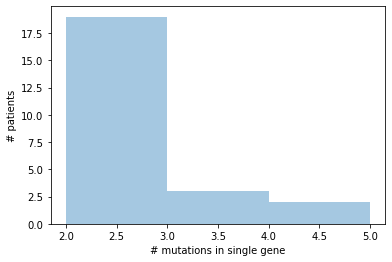

In [312]:
# Plot distribution of patients with at least two mutations.
ax = sns.distplot(
    same_gene_mutations, 
    kde=False,
    bins=[2, 3, 4, 5],
)
ax.set_xlabel('# mutations in single gene')
ax.set_ylabel('# patients')

# Multiple mutations in same gene occurs almost solely in TP53.
same_gene_mutations.groupby('Gene').describe()

## Text analysis

We can borrow some tricks that are also used in text analysis. For example, in the bag-of-words approach one collects all words (the vocabulary) and counts the occurences of each word per text document. I will do the same below: with _gene_ $\leftrightarrow$ _word_ and _text document_ $\leftrightarrow$ _patient_. That is, for each patient (row) count the number of mutations per gene (column). 

In [311]:
# Create an empty data frame first.
dummy_data_frame = pd.DataFrame(
    0,
    # Rows are patients
    index=data_frame['Patient ID'].unique(),
    # Columns are the number of mutations per gene.
    columns=gene_set,
)

# Fill all columns with the number of occurences of each gene per patient.
for ind, patient_genes in data_frame.groupby(columns_to_keep):
    # Unpack patient_id and the gene from the `MultiIndex`.
    patient_id, gene = ind
    # Store number of mutations of this particular gene.
    dummy_data_frame.loc[patient_id][gene] += len(patient_genes)

In [309]:
# Validate that the code above is correct.
assert dummy_data_frame.loc[957]['TP53'] == 2
assert dummy_data_frame.loc[1172]['TP53'] == 4